# Importing Python libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from prettytable import PrettyTable

import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">  
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
<h1><center><strong> XPEV Stock</strong></center></h1>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
        
</div>

# ------------------------------------------------------------------------------------------------------

# Loading dataset

In [2]:
data = pd.read_csv('XPEV_Stock.csv')

# -----------------------------------------------------------------------------------------------------------

<h1><center> Modelling Arima and Sarima</center></h1>

# -----------------------------------------------------------------------------------------------------------

### Seasonality of Close price

<AxesSubplot:xlabel='Date'>

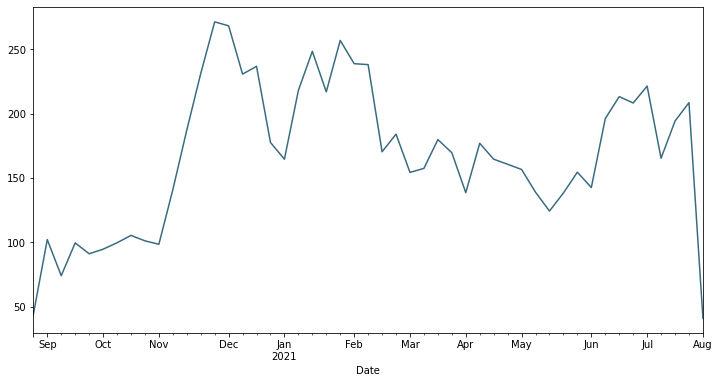

In [72]:
data['Close'] = data['Close'] * 1.0
close_1 = data['Close']
c = '#386B7F'

### Stationarize the Close price data

In [73]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [74]:
def residual_plot(model):
    resid = model.resid
    print(normaltest(resid))
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)
    sns.distplot(resid ,fit = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(resid)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

### Close price with rolling windows

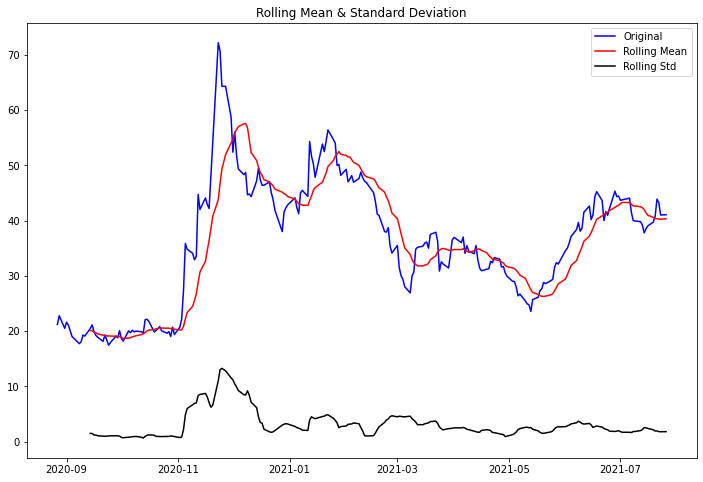

Results of Dickey-Fuller Test:
p-value = 0.3369. The series is likely non-stationary.
Test Statistic                  -1.889670
p-value                          0.336936
#Lags Used                       0.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [75]:
test_stationarity(close_1)

We are going to make data as stationary. So we want to do is take a first difference of the data and it will help to eliminate the overall trend from the data.

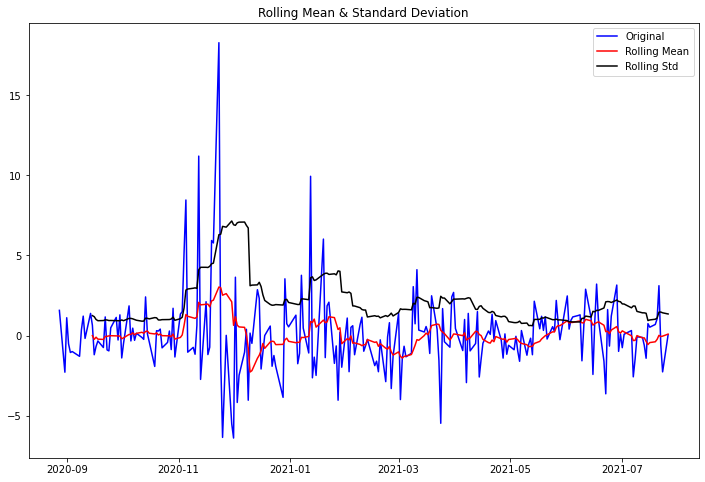

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.410677e+01
p-value                        2.561310e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


In [76]:
first_diff_a = close_1 - close_1.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)

### Plots of ACF and PACF

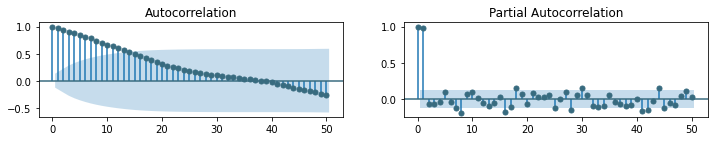

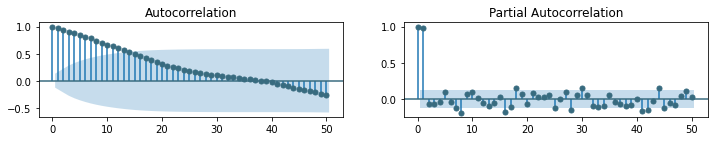

In [77]:
plt.figure(figsize = (12, 8))
plt.subplot(421); plot_acf(close_1, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(close_1, lags = 50, ax = plt.gca(), color = c)

### Splitting the data into training (first 70%) testing (latest 30%)

In [69]:
train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

### Training and testing the ARIMA model

In [72]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    arima = SARIMAX(history_of_train, order=(5,4,1))
    arima_fit = arima.fit(disp=0)
    output = arima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=99.36561399893097, pvalue=2.648689651046097e-22)


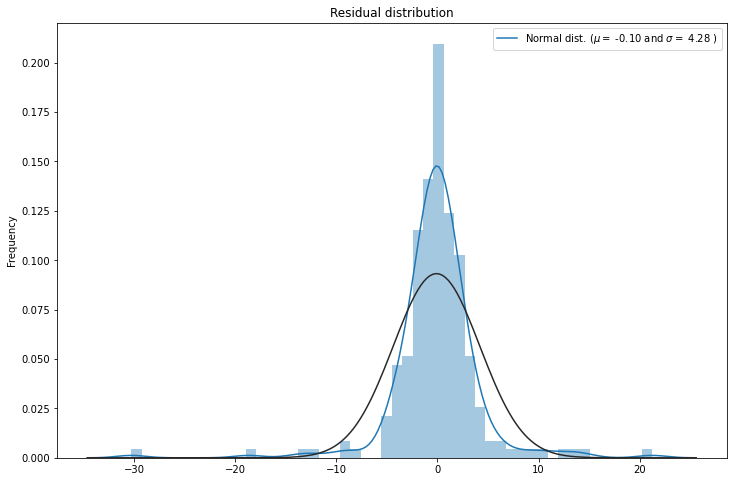

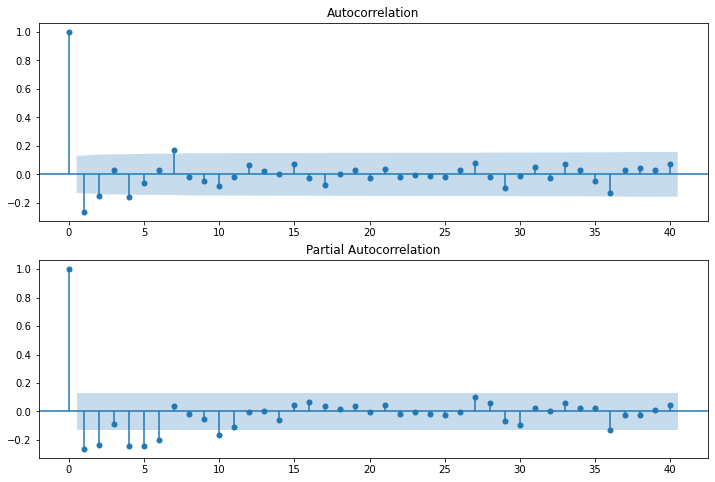

In [73]:
residual_plot(arima_fit)

### Evaluation of Arima Model on Test data

### R2

In [74]:
arima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(arima_test_rs,3))

R Squared :  0.918


### MSE

In [75]:
arima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(arima_test_mse,3))

Mean Squared Error:  3.35


### MAE

In [76]:
arima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(arima_test_MAE,3))

Mean Absolute Error:  1.413


### Predictions and Actual Stock Price

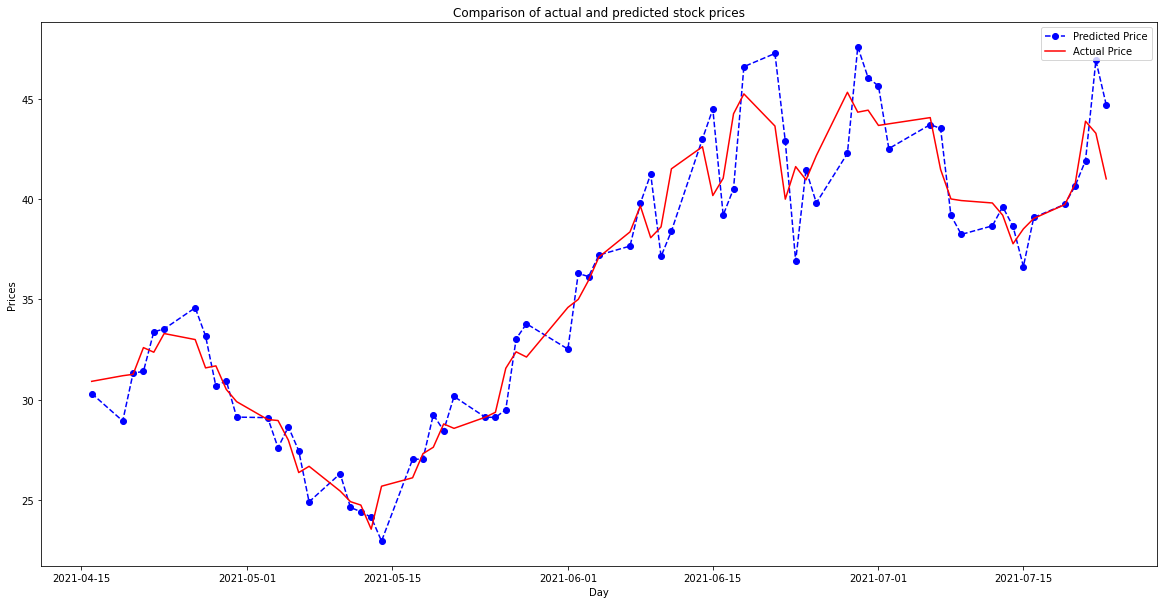

In [77]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

### Training and testing the SARIMA model

In [78]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    sarima = SARIMAX(history_of_train, order=(4,4,0))
    sarima_fit = sarima.fit(disp=0)
    output = sarima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=88.18099489679665, pvalue=7.107882727427261e-20)


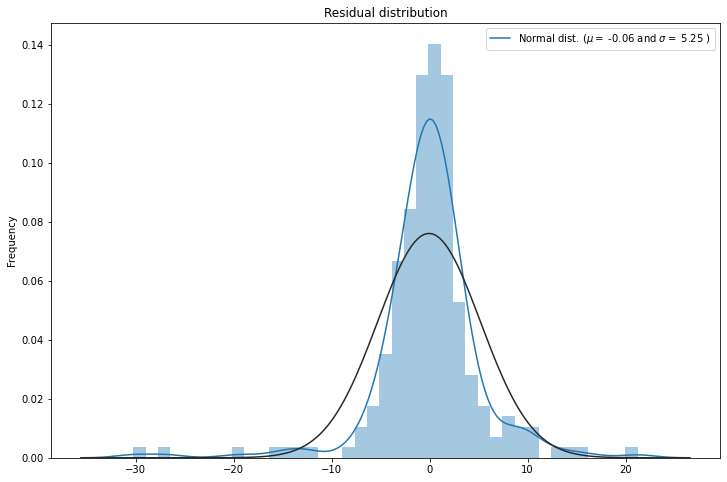

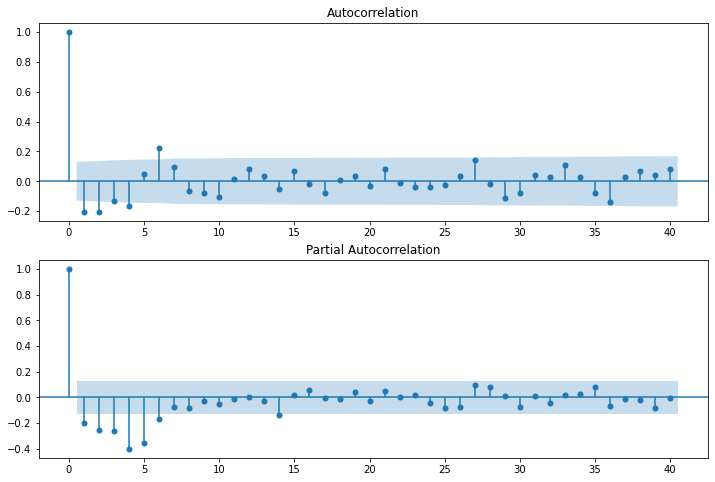

In [79]:
residual_plot(sarima_fit)

### Evaluation of sarima Model on Test data

### R2

In [80]:
sarima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(sarima_test_rs,3))

R Squared :  0.85


### MSE

In [81]:
sarima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(sarima_test_mse,3))

Mean Squared Error:  6.145


### MAE

In [82]:
sarima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(sarima_test_MAE,3))

Mean Absolute Error:  1.853


### Predictions and Actual Stock Price

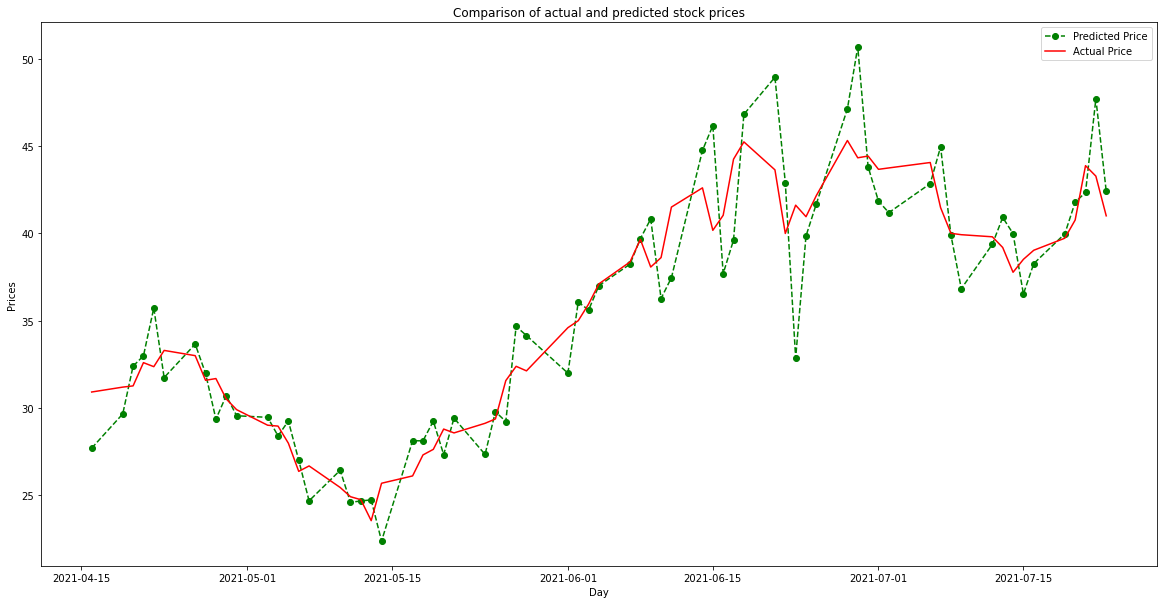

In [83]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Comparison of all algorithms Results on R2 score

In [84]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "R2 Score"]


x.add_row(["Arima Algorithm", round(arima_test_rs,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_rs,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+----------+
|      Model       | R2 Score |
+------------------+----------+
| Arima Algorithm  |  0.918   |
| SARIMA Algorithm |   0.85   |
+------------------+----------+




# Comparison of all algorithms Results on MSE score

In [85]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MSE score"]


x.add_row(["Arima Algorithm", round(arima_test_mse,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_mse,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MSE score |
+------------------+-----------+
| Arima Algorithm  |    3.35   |
| SARIMA Algorithm |   6.145   |
+------------------+-----------+




# Comparison of all algorithms Results on MAE score

In [86]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MAE score"]


x.add_row(["Arima Algorithm", round(arima_test_MAE,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_MAE,3)])

print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MAE score |
+------------------+-----------+
| Arima Algorithm  |   1.413   |
| SARIMA Algorithm |   1.853   |
+------------------+-----------+




# Graph of MSE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

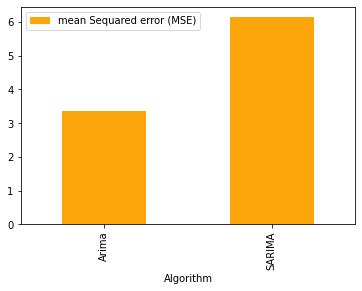

In [87]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'mean Sequared error (MSE)': [arima_test_mse]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean Sequared error (MSE)': [sarima_test_mse]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(.2, .4, 6))
Result_Comp.plot(kind='bar',figsize=(6, 4),stacked=True, color=color, legend=True)

# Graph of R2 of each algorithm

<AxesSubplot:xlabel='Algorithm'>

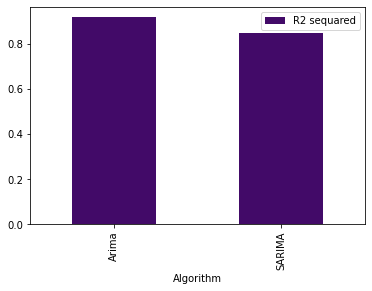

In [88]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'R2 sequared': [arima_test_rs]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'R2 sequared': [sarima_test_rs]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.8, 0.5, 2))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

# Graph of MAE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

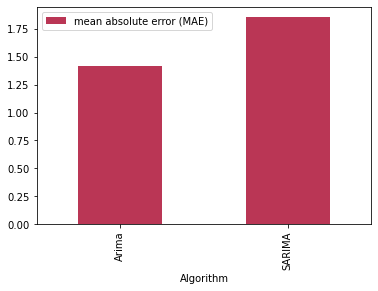

In [89]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'],'mean absolute error (MAE)': [arima_test_MAE]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean absolute error (MAE)': [sarima_test_MAE]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.5, 0.2, 7))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

### Now going to train Sarima on all data and then will fo FORECASTING

In [90]:
Sarima = SARIMAX(data['Close'],order=(4,1,0),seasonal_order=(1,1,1,12),enforce_invertibility=False, enforce_stationarity=False)
Sarima = Sarima.fit()

### FORECASTING

In [91]:
predictions = Sarima.predict(start=len(data), end= len(data)+42, dynamic= True)
predictions

228    40.671931
229    41.259342
230    41.763471
231    41.792070
232    41.771182
233    41.767900
234    42.043881
235    42.065173
236    41.797348
237    41.888392
238    42.035473
239    41.619038
240    41.533759
241    42.587119
242    43.132029
243    43.014427
244    43.053011
245    42.957535
246    43.209827
247    43.211887
248    42.874050
249    42.807364
250    42.996983
251    42.679397
252    42.607330
253    43.685334
254    44.232141
255    44.106754
256    44.148533
257    44.048119
258    44.299168
259    44.300176
260    43.958553
261    43.883320
262    44.075238
263    43.763006
264    43.691653
265    44.770992
266    45.317903
267    45.192094
268    45.234046
269    45.133365
270    45.384347
Name: predicted_mean, dtype: float64

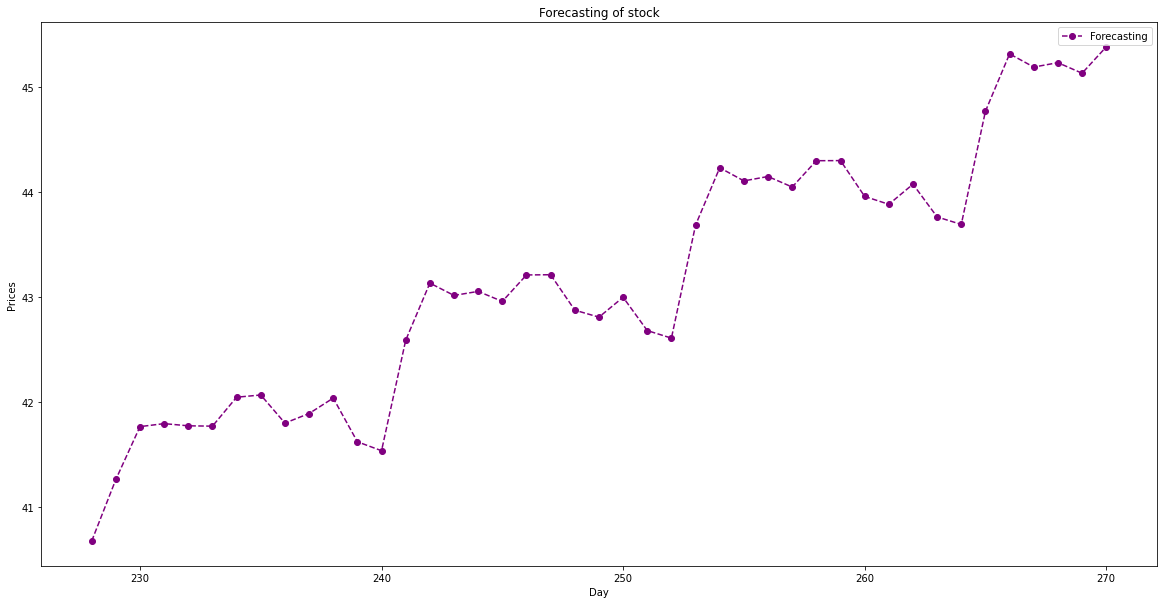

In [92]:
pred=pd.DataFrame(predictions)
pred=pred.rename(columns={'predicted_mean':'Forecasting'})
plt.figure(figsize=(20,10))
plt.plot(pred, color='purple', marker='o', linestyle='dashed',label='Forecasting')
plt.title('Forecasting of stock')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()